In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast
from tqdm import tqdm
import os
import json
import random 
import copy

### 1. Написать класс, который берет два экземпляра классов агентов и играет

In [5]:
weight = False
p = 0.3
alpha = 0.5
percentage = 0.2
bound = 0.01
update_before_rndom_move = True

class AbstractAgent:
    def __init__(self, is_zero):
        # is_zero = True если 0
        # чем ходим what_figure = 1 - крестик , 0 - нолик
        # агент сохраняет необходимую информацию в файл c weights{}.csv
        self.is_zero = is_zero
        self.label = int(not is_zero)
        self.way = []
        if weight:
            self.state_matrix = pd.read_csv('weight{}.csv'.format(self.label), dtype = {'states': object}).set_index('states')
            # Мы можем использовать ast.literal_eval() здесь, чтобы оценить строку как выражение Python
            self.state_matrix['prob_moves'] = self.state_matrix['prob_moves'].apply(lambda x: ast.literal_eval(x))
        else:
            self.state_matrix = state_generate(self.is_zero)
    def get_action(self, state):
        # state - список списков - доска 3x3 [[-1,-1,-1], [-1,-1,-1], [-1,-1,-1]]
        #                           крестик - 1, нолик - 0, пусто - -1
        # текущее положение
        now_state = self.state_matrix.loc[get_code_from_state(state)]
        # возможные движения
        pos_move = pd.DataFrame(now_state['probable_moves'])
        if np.random.random() < p:
            new_state = pos_move.sample(n = 1).iloc[0]
            new_state_value = self.state_matrix.loc[new_state['state'], 'value']
            self.way.append(((now_state.name, now_state.value), (new_state['state'], new_state_value)))
        else:
            pos_move['value'] = pos_move['state'].apply(lambda x: self.state_matrix.loc[x, 'value'])
            new_state = pos_move[pos_move['value']==pos_move['value'].max()].iloc[0]
            new_state_value = self.state_matrix.loc[new_state['state'], 'value']
            self.way.append(((now_state.name, now_state.value), (new_state['state'], new_state_value)))
        return new_state['move'] # координаты поля, куда ходит агент 
    
    def save_weight(self):
        # сохраняем матрицу весов в csv
        self.state_matrix.to_csv('weight{}.csv'.format(self.label))
    def is_done(self, state, reward): #переимен set_reward_and_state
        # reward - вознаграждение 1 если выиграли , вызывается когда игра закончена
        if reward == 1:
            for move in self.way[::-1]:
                self.state_matrix.loc[move[0][0], 'value'] = move[0][1] + alpha * (move[1][1] - move[0][1])

In [6]:
class AbstractAgent_e:
    def __init__(self, is_zero, inheritance, parent_weights):
    #is_zero == True если нолик
        self.is_zero = is_zero
        self.label = int(not is_zero)
        # если это дочерний класс
        if inheritance:
            self.state_matrix = change_states_val(parent_weights, percentage, bound)
        else:
            if weight:
                self.state_matrix = pd.read_csv('weight_e{}.csv'.format(self.label), dtype={'states': object}).set_index('states')
                self.state_matrix['prob_moves'] = self.state_matrix['prob_moves'].apply(lambda x: ast.literal_eval(x))
            else: # эволюционный генератор
                self.state_matrix = state_generate_evolut(self.label)
    def get_action(self, state):
        now_state = self.state_matrix.loc[get_code_from_state(state)]
        pos_move = pd.DataFrame(now_state['probable_moves'])
        pos_move['value'] = pos_move['state'].apply(lambda x: self.state_matrix.loc[x, 'value'])
        new_state = pos_move[pos_move['value']==pos_move['value'].max()].iloc[0]
        return new_state['move']
    def save_weight(self):
        self.state_matrix.to_csv('weight_e{}.csv'.format(self.label))
    def is_done(self, state, reward):
        return 0

In [7]:
# проверка победы
def check_reward (state, label):
    for i in range(3):
        # проверка по строкам
        if np.all(state[i,:] == int(label)):
            return True
        # проверка по столбцам
        elif np.all(state[:,i] == int(label)):
            return True
        # проверка на обратной дигонали
    if np.all(np.fliplr(state).diagonal() == int(label)):
        return True
    # проверка эл-в на диагонали
    if np.all(state.diagonal() == int(label)):
        return True
    return False

In [8]:
# Вывод состояния поля в виде матрицы - ищем цифры, отнимаем 1 и преобразуем в матрицу
def get_state_from_code(code):
    return np.array(re.findall(r'\d', code)).reshape((3,3)).astype(int) - 1

In [9]:
# Вывод состояния поля по матрице состояния
def get_code_from_state(state):
    result = ''
    for s in (state.flatten() + 1).astype('str'):
        result += s
    return result

Функция выбора след.хода

In [10]:
# получение индексов свободных полей
def get_free_field(state):
    index = []
    for i in range(3):
        for j in range(3):
            if state[i][j] == -1: # поле пусто
                index.append((i, j))
    return index

In [11]:
# получение следующих возможных ходов
def get_probable_move_from_code(state, label):
    label = str(int(label) + 1)
    states = {'state':[], 'move':[]}
    for i in range(len(state)):
        if state[i] == '0': #пустая клетка
            states['state'].append(state[:i]+label+state[i+1:])
            states['move'].append((i // 3, i % 3))
    return states

In [12]:
# создание генератора состояний со следующими ходами
def state_generate(label):
    states = []
    values = []
     # координаты поля, куда ходит агент нумерация с 0, те 0,1,2, всего 9 позиций, т.е.3^9
    for i in range(19683):
        s = np.base_repr(i, base = 3) # строковое представление в троичной системе
        s = '0'*(9 - len(s)) + s
        states.append(s)
        # Ценность выигрышного состояния - 1
        if check_reward(get_state_from_code(s), label):
            values.append(1)
        # Ценность остальных состояний  - 0.5    
        else:
            values.append(0.5)
    states = np.array(states)
    pos_st = []
    for state_code in states:
        pos_st.append(get_probable_move_from_code(state_code, label))
    return pd.DataFrame({'states': states, 'value': values, 'probable_moves': pos_st}).set_index('states')

In [13]:
# проведение 1 раунда
def round_of_play(agent_zeros, agent_cross, print_state = False):
    state = (np.zeros((3,3))-1).astype(int) #поле заполнено -1
    while -1 in state:
        # ход крестика
        state[agent_cross.get_action(state)] = 1
        if print_state:
            print(state)
            print()
        if check_reward(state, 1):
            agent_cross.is_done(state, True)
            agent_zeros.is_done(state, False)
            return 1 # победа крестика
        if not(-1 in state):
            break
        # ход нолика
        state[agent_zeros.get_action(state)] = 0
        if print_state:
            print(state)
            print()
        if check_reward(state, 0):
            agent_cross.is_done(state, False)
            agent_zeros.is_done(state, True)
            return 0 # победа нолика
     # никто не победил   
    agent_cross.is_done(state, False)
    agent_zeros.is_done(state, False)
    return -1

### 2. Реализовать игроков на на основе обучения с подкреплением

In [14]:
def fit(agent_zeros, agent_cross, epochs, step_per_epoch, save_config = False, plot_win = False):
    history = {
        'epoch':[], 
        'zeros_win':[],
        'cross_win':[],
        'draw':[]
    }
    for epoch in tqdm(np.arange(epochs)):
        z_win = 0
        c_win = 0
        draw = 0
        for step in np.arange(step_per_epoch):
            play_result = round_of_play(agent_zeros, agent_cross)
            if play_result == 0:
                z_win += 1
            elif play_result == 1:
                c_win += 1
            else:
                draw += 1 # ничья
        history['epoch'].append(epoch)
        history['zeros_win'].append(z_win)
        history['cross_win'].append(c_win)
        history['draw'].append(draw)
    history = pd.DataFrame(history)
    if plot_win:
        plt.figure(figsize = (10, 8))
        plt.plot(history['epoch'], (history['zeros_win']/step_per_epoch)*100, 'b-', label = '% побед нулика в эпохе')
        plt.plot(history['epoch'], (history['cross_win']/step_per_epoch)*100, 'r-', label = '% побед крестика в эпохе')
        plt.plot(history['epoch'], (history['draw']/step_per_epoch)*100, 'g-', label = '% ничьей в эпохе')
        plt.xlim([0,epochs])
        plt.ylim([0,101])
        plt.grid()
        plt.legend()
        plt.show()
    if save_config:
        agent_cross.save_weight()
        agent_zeros.save_weight()

In [15]:
get_state_from_code('222211010')

array([[ 1,  1,  1],
       [ 1,  0,  0],
       [-1,  0, -1]])

In [16]:
get_code_from_state(np.array([[ 1,  1,  1],[ 1,  0,  0], [-1, -1, -1]]))

'222211000'

In [17]:
get_probable_move_from_code('222011010', 1)

{'state': ['222211010', '222011210', '222011012'],
 'move': [(1, 0), (2, 0), (2, 2)]}

In [18]:
get_probable_move_from_code('000000000', 0)

{'state': ['100000000',
  '010000000',
  '001000000',
  '000100000',
  '000010000',
  '000001000',
  '000000100',
  '000000010',
  '000000001'],
 'move': [(0, 0),
  (0, 1),
  (0, 2),
  (1, 0),
  (1, 1),
  (1, 2),
  (2, 0),
  (2, 1),
  (2, 2)]}

In [19]:
state_generate(False) #нолики

,value,probable_moves
states,,
000000000,0.5,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.5,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.5,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.5,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.5,"{'state': ['100000011', '010000011', '00100001..."
...,...,...
222222211,0.5,"{'state': [], 'move': []}"
222222212,0.5,"{'state': [], 'move': []}"
222222220,0.5,"{'state': ['222222221'], 'move': [(2, 2)]}"


In [20]:
state_generate(True) #крестики

,value,probable_moves
states,,
000000000,0.5,"{'state': ['200000000', '020000000', '00200000..."
000000001,0.5,"{'state': ['200000001', '020000001', '00200000..."
000000002,0.5,"{'state': ['200000002', '020000002', '00200000..."
000000010,0.5,"{'state': ['200000010', '020000010', '00200001..."
000000011,0.5,"{'state': ['200000011', '020000011', '00200001..."
...,...,...
222222211,1.0,"{'state': [], 'move': []}"
222222212,1.0,"{'state': [], 'move': []}"
222222220,1.0,"{'state': ['222222222'], 'move': [(2, 2)]}"


#### 1 раунд

In [21]:
zeros = AbstractAgent(True)
cross = AbstractAgent(False)

In [22]:
#1 - победа крестика, 0 - победа нулика, -1 - ничья
round_of_play(zeros, cross, print_state = True)

[[ 1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]

[[ 1 -1  0]
 [-1 -1 -1]
 [-1 -1 -1]]

[[ 1  1  0]
 [-1 -1 -1]
 [-1 -1 -1]]

[[ 1  1  0]
 [ 0 -1 -1]
 [-1 -1 -1]]

[[ 1  1  0]
 [ 0  1 -1]
 [-1 -1 -1]]

[[ 1  1  0]
 [ 0  1 -1]
 [-1 -1  0]]

[[ 1  1  0]
 [ 0  1  1]
 [-1 -1  0]]

[[ 1  1  0]
 [ 0  1  1]
 [-1  0  0]]

[[1 1 0]
 [0 1 1]
 [1 0 0]]



-1

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [7:16:34<00:00, 261.95s/it]


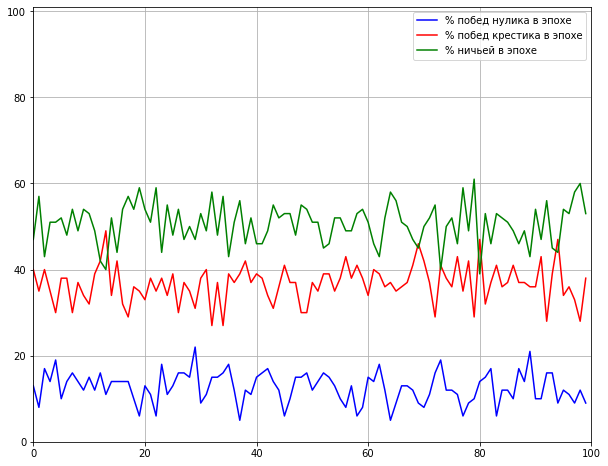

In [20]:
zeros = AbstractAgent(True)
cross = AbstractAgent(False)
fit(zeros, cross, epochs = 100, step_per_epoch = 100, save_config = True, plot_win = True)

### 3. Реализовать игроков на на основе эволюционного подхода

In [23]:
#Начальная инициализация
#Случайное распределение весов у стратегий
import numpy as np
#генерация состояний со следующими ходами
def state_generate_evolut(label):
    states = []
    values = []
    for i in range(19683):
        s = np.base_repr(i,base=3)
        s = '0'*(9-len(s)) + s
        states.append(s)
        if check_reward(get_state_from_code(s), label):
            values.append(1)
        else:
            values.append(np.random.sample())
    states = np.array(states)
    pos_st = []
    for state_code in states:
        pos_st.append(get_probable_move_from_code(state_code, label))
    return pd.DataFrame({'states':states, 'value':values,'probable_moves':pos_st}).set_index('states')

In [24]:
s = state_generate_evolut(False)
s.head()

,value,probable_moves
states,,
000000000,0.023483,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.530314,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.934491,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.209090,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.279085,"{'state': ['100000011', '010000011', '00100001..."


In [25]:
s.index[1]

'000000001'

In [26]:
# изменение весов
# perc – доля объектов, которые надо изменить
def change_states_val(state_tab, perc, bound):
    state_table = state_tab.copy()
    
    rows_cnt = round(state_table.shape[0] * perc,)
    ind_ch = np.random.randint(0, state_table.shape[0], rows_cnt)
    for i in ind_ch:
        state_table.loc[state_table.index[i],'value'] = (state_table.loc[state_table.index[i],'value'] 
                                                +(np.random.random() - .5)*2*bound)
    return state_table

In [27]:
change_states_val(s, 0.7, 0.1).head()

,value,probable_moves
states,,
000000000,0.023483,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.530314,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.984463,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.250830,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.114810,"{'state': ['100000011', '010000011', '00100001..."


#### Наследование
Родитель

In [28]:
ev_agent_zeros = AbstractAgent_e(is_zero = True, inheritance = False, parent_weights = False)

In [29]:
ev_agent_zeros.state_matrix.head()

,value,probable_moves
states,,
000000000,0.777860,"{'state': ['100000000', '010000000', '00100000..."
000000001,0.386424,"{'state': ['100000001', '010000001', '00100000..."
000000002,0.067879,"{'state': ['100000002', '010000002', '00100000..."
000000010,0.530108,"{'state': ['100000010', '010000010', '00100001..."
000000011,0.593457,"{'state': ['100000011', '010000011', '00100001..."


Потомок

In [30]:
son_zeros = AbstractAgent_e(is_zero = ev_agent_zeros.is_zero, inheritance = True,  parent_weights = ev_agent_zeros.state_matrix)

In [31]:
((son_zeros.state_matrix == ev_agent_zeros.state_matrix)==False).sum()['value']/son_zeros.state_matrix.shape[0]

0.1817812325356907

18% параметров потомка отличаются от родителя (максимум задан гиперпараметром)

### 4. Пpоведём состязание

In [32]:
def get_pinnacle_of_evolution(label, size_of_population, epochs, step_per_epochs, is_rival, rival_agent):
    #rival может быть задан изначально, тогда агенты будут тестироваться на нем. Возвращается 1 агент
    #Иначе создается две популяции с 0 и Х, возвращается два лучших агента
    if is_rival:
        #Начальная популяция
        #[[agent, %побед], [agent, %побед],...]
        population = [[AbstractAgent_e(is_zero = not(label), inheritance = False, parent_weights = False),
                       0] for _ in range(size_of_population)]
        for epoch in tqdm(range(epochs)):
            #каждый играет с заданным соперником step_per_epochs раз
            #round_of_play возвращает label победителя, если это label популяции, то эволюционный агент победил
            for i in range(size_of_population):
                win_i = 0
                if label == 0:
                    for _ in range(step_per_epochs):
                        win_i += int(round_of_play(population[i][0], rival_agent, print_state = False)==label)
                else:
                    for _ in range(step_per_epochs):
                        win_i += int(round_of_play(rival_agent, population[i][0], print_state = False)==label)
                population[i][1] = (win_i/step_per_epochs)*100
            #отбираем 50% лучших
            selection_limit = pd.Series([agent_score[1] for agent_score in population]).quantile(0.5)
            agent_id = 0
            while agent_id < len(population):
                if population[agent_id][1] < selection_limit:
                    del population[agent_id]
                else:
                    agent_id += 1
            #генерируем потомков
            new_pop = []
            for agent_score in population:
                new_pop.append([
                    AbstractAgent_e(is_zero = agent_score[0].is_zero, inheritance = True,
                                  parent_weights = agent_score[0].state_matrix),
                    0
                ])
            population = population + new_pop
        best_score = pd.Series([agent_score[1] for agent_score in population]).max()
        for agent_score in population:
            if agent_score[1] == best_score:
                return agent_score[0]

In [33]:
ev_agent = get_pinnacle_of_evolution(1, size_of_population=50, epochs=20,
                                     step_per_epochs=50, is_rival=True, rival_agent=zeros)

100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [24:05:34<00:00, 4336.75s/it]


### 5. Дополнение: победить https://github.com/dutch-police/TicTacToe/blob/fb508335bc3a86faecb5c1c60d3bee94292f4635/tictactoe.ipynb

In [34]:
class Game:
    
    def __init__(self, field=None):
        self.field = None
        
        if field:
            self.field = field
        else:
            self.start()
    
    def start(self):
        self.field = [' ']*9

    def printField(self):
        row = ''
        for i in range(len(self.field)):
            cell = self.field[i]
            row+='['
            if cell != ' ':
                row+=cell
            else:
                row+=str(i+1)
            row+=']'
            if (i % 3 == 2): 
                print(row)
                row = ''
    
    def set(self, position, side):
        pos = int(position)-1
        self.field[pos] = side

    def getFree(self):
        free = []
        for i in range(len(self.field)):
            cell = self.field[i]
            if (cell == ' '):
                free.append( (i+1) )
        return free
    
    def isDraw(self):
        free = self.getFree();
        return len(free)==0;
    def isWin(self, side):
        for i in range(3):
            isW = True 
            for j in range(3):
                if self.field[i*3+j]!=side:
                    isW = False
                    break
            if isW:
                return isW
            
        for i in range(3):
            isW = True 
            for j in range(3):
                if self.field[j*3+i]!=side:
                    isW = False
                    break
            if isW:
                return isW
            
        isW = True;
        for i in range(3):
            if self.field[i*3+i]!=side:
                isW = False
                break
        if isW:
            return isW
        
        isWi = True;
        for i in range(3):
            if self.field[(i*3+2-i)]!=side:
                isW = False
                break
        if isW:
            return isW

        return False
    
    def getState(self, side):
        if side == 'x':
            return self.field

        newField = ''
        for i in range(len(self.field)):
            if self.field[i]=='x':
                newField += 'o'
            elif self.field[i]=='o':
                newField += 'x'
            else:
                newField += self.field[i] 

        return newField


In [35]:
class AI:
    def __init__(self):
        self.table = {}
        if os.path.isfile('./rewards.json'):
            with open('rewards.json') as json_file:
                self.table = json.load(json_file)
                print("loaded AI from rewards.json")

    def getReward(self, state):
        game = Game(state)
        
        #если победитель - мы, то оценка состояния игры "1"
        if game.isWin('x'):
            return 1

        #если победиль - соперник, то оценка состояния игры "0"
        if game.isWin('o'):
            return 0

        #смотрим ценность по таблице
        strstate = ''.join(state)
        if strstate in self.table.keys():
            return self.table[strstate]

        #если в таблице нет, то считаем начальной ценностью "0.5"
        return 0.5

    def correct(self, state, newReward):
        oldReward = self.getReward(state)
        strstate = ''.join(state)
        self.table[strstate] = oldReward + 0.1 * (newReward - oldReward)

    def save(self):
        with open('rewards.json', 'w') as outfile:
            json.dump(self.table, outfile)

In [36]:
class AIPlayer:
    
    def __init__(self, side, ai, isGreedy=True):
        self.side = side
        self.ai = ai
        self.oldState = None
        self.isGreedy = isGreedy

    def getSide(self):
        return self.side

    def makeStep(self, game):
        #получаем список доступных ходов
        free = game.getFree()
        
        #решаем, является ли текущий ход 
        #зондирующим (случайным) или жадным (максимально выгодным)
        
        if not self.isGreedy:
            #случайный ход
            print('Random step')
            step = random.choice(free)
            game.set(step, self.side)
            self.oldState = game.getState(self.side)
            return step

        #жадный ход
        rewards = {}
        for step in free:
            # для каждого доступного хода оцениваем состояние игры после него
            newGame = copy.deepcopy(game)
            newGame.set(step, self.side)
            rewards[step] = self.ai.getReward(newGame.getState(self.side))

        #выясняем, какое вознаграждение оказалось максимальным
        maxReward = 0
        for reward in rewards.values():
            if reward > maxReward:
                maxReward = reward

        #находим все шаги с максимальным вознаграждением
        steps = []
        
        for step in rewards:
            reward = rewards[step]
            if (maxReward > (reward - 0.01)) and (maxReward < (reward + 0.01)):
                steps.append(step)

        #корректируем оценку прошлого состояния
        #с учетом ценности нового состояния
        if (self.oldState):
            self.ai.correct(self.oldState, maxReward)

        #выбираем ход из ходов с максимальный вознаграждением
        step = random.choice(steps)
        game.set(step, self.side)

        #сохраняем текущее состояние для того, 
        #чтобы откорректировать её ценность на следующем ходе
        self.oldState = game.getState(self.side)
        return step

    def loose(self):
        #корректируем ценность предыдущего состояния при проигрыше
        if self.oldState:
            self.ai.correct(self.oldState, 0)

    def win(self):
        #корректируем ценность предыдущего состояния при выигрыше
        if self.oldState:
            self.ai.correct(self.oldState, 1)
            
    def draw(self):
        #корректируем ценность предыдущего состояния при ничьей
        if self.oldState:
            self.ai.correct(self.oldState, 0.5)

In [37]:
class UserPlayer:

    def __init__(self, side):
        self.side = side

    def getSide(self):
        return self.side

    def makeStep(self, game):
        game.printField()
        
        free = game.getFree()

        inp = None
        while (True):
            inp = input()
            if int(inp) in free:
                break
        
        game.set(inp, self.side)

    def loose(self):
        print('you loose')

    def win(self):
        print('you win')
        
    def draw(self):
        print('draw')

In [38]:
def state_to_gmstate(state):
    """
    Переводим состояние игры из формата массива в формат строки,
    который используется игрой
    """
    gmstate = []
    for row in state:
        for ch in row:
            if ch == -1:
                gmstate.append(' ')
            elif ch == 1:
                gmstate.append('x')
            else:
                gmstate.append('o')
    return gmstate
def gmstep_to_step(step):
    """
    Переводим обозначение хода из принятого в игре 
    в формат который ожидается на выходе агента
    """
    steps = {
        1:(1,1),
        2:(1,2),
        3:(1,3),
        4:(2,1),
        5:(2,2),
        6:(2,3),
        7:(3,1),
        8:(3,2),
        9:(3,3),
    }
    return (steps[step][0]-1,steps[step][1]-1)

In [39]:
class AgentTicTacGreedy:
    def __init__(self, is_zero):
        #is_zero == True если нолик
        self.player = None
        ai = AI()
        if is_zero:
            self.player = AIPlayer('o', ai, True)
        else:
            self.player = AIPlayer('x', ai, True)

    def get_action(self, state):
        # пример state = [[1,0,1],[0,1,0],[0,1,0]] 1 - это крестик, 0 - это нолик, -1 - пусто
        gmstate = state_to_gmstate(state)
        game = Game(field=gmstate)
        move = self.player.makeStep(game)
        return gmstep_to_step(move) # возвращаем координаты хода

    def is_done(self, state, reward):
        # reward - вознаграждение 1 если выиграли , вызывается когда игра закончена
        gmstate = state_to_gmstate(state)
        game = Game(field=gmstate)
        return game.isWin(self.player.getSide())

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:02<00:00, 15.13s/it]


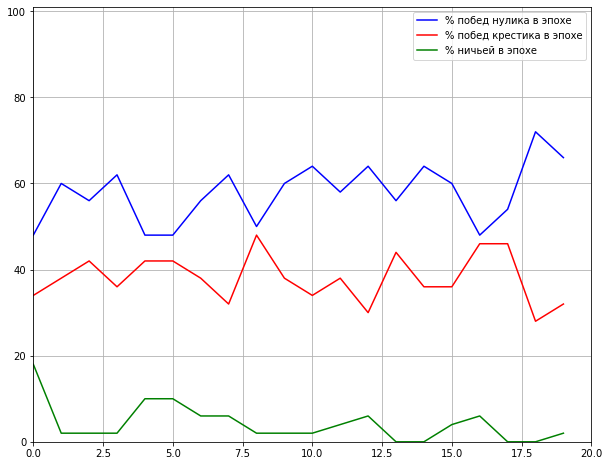

In [41]:
zeros = AbstractAgent(True)
ones = AgentTicTacGreedy(False)
fit(zeros, ones, epochs = 20, step_per_epoch = 50, save_config = False, plot_win = True)

#### Вывод: 
Процент выигрыша нашей модели выше, чем у предлагаемой для сравнения модели.